# Notebook to Train SIREN Models for Neural Implicit Representations of Proteins
A lot of the code in this notebook is based on the Colab notebook offered by the original authors of the SIREN paper, Vincent Sitzmann*, Julien N. P. Martel*, Alexander Bergman, David B. Lindell, and Gordon Wetzstein. This notebook can be found here: https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [1]:
# Library installations

'''
!pip install -U scikit-image
!pip install gemmi
'''

'\n!pip install -U scikit-image\n!pip install gemmi\n'

In [22]:
# Imports

import torch # https://pytorch.org/
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

import numpy as np
import skimage
import matplotlib # This is imported solely to see version
import matplotlib.pyplot as plt

import scipy.ndimage

import time
import gc

import gemmi # https://gemmi.readthedocs.io/en/latest/

In [26]:
print('PyTorch Version:', torch.__version__)
print('NumPy Version:', np.__version__)
print('scikit-image Version:', skimage.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('SciPy Version:', scipy.ndimage.__version__)
print('Gemmi Version:', gemmi.__version__)

1.4.0
1.19.2
0.18.1
3.3.2
2.0
0.4.2


In [3]:
# Helper Functions

def get_mgrid(sidelen, dim=3):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [4]:
# SIREN Model Definition

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Use the cell below to select which protein to import and use
The two cells below are where more protein structures can be added

- t20s: T20S proteasome (https://www.ebi.ac.uk/pdbe/emdb/empiar/entry/10025/)
- trpv1: TRPV1 in complex with DkTx and RTX, determined in lipid nanodisc (https://www.ebi.ac.uk/pdbe/emdb/empiar/entry/10059/)
- rnlrp1: rNLRP1-rDPP9 complex (https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-30458)

In [5]:
protein = 't20s' # One of 't20s', 'trpv1', 'rnlrp1'

In [6]:
if protein == 't20s':
    downsample_factor = 0.5 # Structure is downsampled to 1/2 of the size
    cropping = 50 # 50 pixels cropped from each side of each axis

    # Getting test T20S map
    if not os.path.exists('emd_6287.map.gz'):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    if not os.path.exists('emd_6287.map'):
        !gunzip 'emd_6287.map.gz'
    map_path = 'emd_6287.map'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map(map_path)
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
elif protein == 'trpv1':
    downsample_factor = 0.75 # Structure is downsampled to 3/4 of the size
    cropping = 30 # 30 pixels cropped from each side of each axis

    # Getting test TRPV1 map
    map_filename = 'emd_8117.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8117/map/emd_8117.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_8117.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_8117.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
elif protein == 'rnlrp1':
    downsample_factor = 0.5 # Structure is downsampled to 1/2 of the size
    cropping = 40 # 40 pixels cropped from each side of each axis

    # Getting test rNLRP1-rDPP9 map
    map_filename = 'emd_30458.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_30458.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_30458.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
else:
    assert False, "Non-valid protein specified"

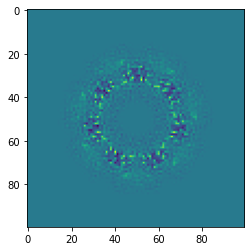

In [7]:
# Showing x-axis central slice of structure to be used for training

plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()

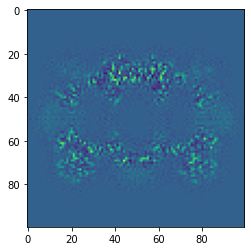

In [8]:
# Showing y-axis central slice of structure to be used for training

plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()

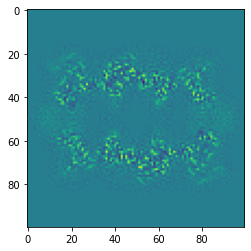

In [9]:
# Showing z-axis central slice of structure to be used for training

plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()

In [10]:
# Processing data for training

class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = torch.from_numpy(img)
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.reshape(-1, 1)
        self.coords = get_mgrid(sidelength, 3)

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        
            
        return self.coords[idx], self.pixels[idx]
    
protein_dataset = ImageFitting(structure, structure.shape[0])

## SIREN model hyperparameters can be selected in the cell below

- in_features: number of dimensions of structure used for training (ie, 2 for 2D, 3 for 3D)
- out_features: number of values outputted per coordinate
- hidden_features: number of hidden features per layer
- hidden_layers: number of layers
- outermost_linear: Add a linear layer to the end of the network
- first_omega_0: omega value of initial layer (omega value is used to tune spatial frequency of layers)
- hidden_omega_0: omega value of all layers after initial layer (omega value is used to tune spatial frequency of layers)

In [11]:
in_features = 3
out_features = 1
hidden_features = 256
hidden_layers = 7
outermost_linear = True
first_omega_0 = 50
hidden_omega_0 = 50

In [12]:
# Initializing SIREN Model

# Clears memory
torch.cuda.empty_cache()
gc.collect()

siren_model = Siren(in_features=in_features, out_features=out_features, hidden_features=hidden_features, 
                  hidden_layers=hidden_layers, outermost_linear=outermost_linear, first_omega_0=first_omega_0, 
                    hidden_omega_0=hidden_omega_0)
siren_model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Training hyperparameters can be selected in the cell below

In [13]:
num_epochs = 300
epochs_per_summary = 1
learning_rate = 1e-6
batch_size = 256

In [ ]:
# Training loop

dataloader = DataLoader(protein_dataset, batch_size=batch_size, pin_memory=True, num_workers=0)
optim = torch.optim.Adam(lr=learning_rate, params=siren_model.parameters())

loss_vals = []
for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    epoch_loss = 0.0
    for batch, data in enumerate(dataloader):
        model_input, ground_truth = data
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        
        optim.zero_grad()
    
        model_output, coords = siren_model(model_input)    
        loss = ((model_output - ground_truth)**2).mean()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
            
    epoch_loss /= len(dataloader)
    loss_vals.append(epoch_loss)
    if epoch % epochs_per_summary == epochs_per_summary - 1:
        print("Epoch: %d, Loss %0.9f" % (epoch + 1, epoch_loss))
    epoch_loss = 0.0

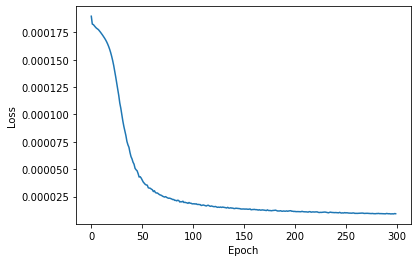

In [15]:
# Plotting training loss

plt.plot(loss_vals)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Filename of saved SIREN model can be selected in the cell below
PyTorch convention has PyTorch models saved with the extension '.pt'.

In [16]:
model_filename = 'siren_model.pt'

In [17]:
# Saving model

torch.save(siren_model, model_filename)

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Siren. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SineLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
